# Notebook de Modélisation - du prétraitement aux prédictions
Le notebook ou code de la modélisation (du prétraitement à la prédiction), intégrant via MLFlow le tracking d’expérimentations et le stockage centralisé des modèles.  

L'analyse exploratoire utilise de façon exhaustive l'approche de **Will Koehrsen** : https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction/  

Le modèle LightGBM s'inspire essentiellement de **Aguiar** : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script  

Les données sont fournies pour la compétition Kaggle **Home Credit Default Risk** : https://www.kaggle.com/c/home-credit-default-risk/data  


## Imports


In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# Garbage Collector
import gc

# Dealing with NaN
from sklearn.impute import SimpleImputer

# Models
from sklearn.dummy import DummyClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline

# MLflow
import mlflow
from mlflow import log_metric, log_param, log_params, log_artifacts
from mlflow.models import infer_signature

# Metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import time
from contextlib import contextmanager
import re
from joblib import dump, load

In [2]:
def distrib_score(data, categ):
    """Affiche un pie plot représentant la distribution d'une variable catégorielle.
    
    data : DataFrame
    categ : nom d'une variable catégorielle dans data
    """
    nb_per_grade = data[categ].value_counts()
    plt.pie(x=nb_per_grade.values, labels=nb_per_grade.index)
    plt.title(f"Distribution de variable quali {categ}")
    plt.legend(loc=(1.3,0.5))  # Place le coin en bas à gauche de la legende
    plt.show()
    
    
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Count the number of colomns with more than 50% missing information
        mis_val_table_50 = mis_val_table_ren_columns[
            mis_val_table_ren_columns['% of Total Values'] > 50]
        less_than_50_columns = mis_val_table_50.index.to_list()
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        print("There is ", len(less_than_50_columns), 
              "columns with more than 50% missing values. \n")
        print(less_than_50_columns)
        display(mis_val_table_ren_columns)
        
        # Return the dataframe with missing information
        return less_than_50_columns


# Function to calculate correlations with the target for a dataframe
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        #print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    corrs = pd.DataFrame(corrs)
    
    return corrs


# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)
    
    plt.show()

In [3]:
def impute_numeric_nan(df): 
    
    numeric_columns = [col for col in df.columns if df[col].dtype != 'object']
    for num_col in numeric_columns : 
        strategy_median = df[num_col].median(skipna=True)
        df[num_col] = df[num_col].fillna(value=strategy_median)
    return df


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Preprocess application_train.csv
def application_train(num_rows = None, nan_as_category = True):
    # Read data
    df = pd.read_csv(path + 'application_train.csv', nrows= num_rows)
    print("Number of samples: {}".format(len(df)))

    # Remove 4 applications with XNA CODE_GENDER 
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Fill NaN in numerical columns
    df = impute_numeric_nan(df)
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    return df


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path + 'bureau.csv', nrows = num_rows)
    # Fill NaN in numerical columns
    bureau = impute_numeric_nan(bureau)
    
    bb = pd.read_csv(path + 'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path + 'previous_application.csv', nrows = num_rows)
    prev = prev.drop(prev[prev['AMT_CREDIT'].isnull()].index)
    prev = impute_numeric_nan(prev)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path + 'POS_CASH_balance.csv', nrows = num_rows)
    pos = impute_numeric_nan(pos)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg


# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path + 'installments_payments.csv', nrows = num_rows)

    # Difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Fill NaN with median strategy
    ins = impute_numeric_nan(ins)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }

    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg


# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path + 'credit_card_balance.csv', nrows = num_rows)
    cc = impute_numeric_nan(cc)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


def impute_nan (df) : 
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')

    df_array = imputer.fit_transform(df)

    df = pd.DataFrame(df_array, columns=df.columns)
    
    return df

In [4]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
    

# Preprocess application.csv
def application(df, num_rows = None, nan_as_category = True):
    # Read data
    print("Number of samples: {}".format(len(df)))

    # Remove 4 applications with XNA CODE_GENDER 
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Fill NaN in numerical columns
    df = impute_numeric_nan(df)
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    return df


def make_data (df): 
    
    with timer("Process application"):
        df = application(df)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance()
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
        df = impute_nan(df)
    with timer("Process previous_applications"):
        prev = previous_applications()
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
        df = impute_nan(df)
    with timer("Process POS-CASH balance"):
        pos = pos_cash()
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
        df = impute_nan(df)
    with timer("Process installments payments"):
        ins = installments_payments()
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
        df = impute_nan(df)
    with timer("Process credit card balance"):
        cc = credit_card_balance()
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        df = impute_nan(df)
    
    return df


def split_the_data (debug= False):
    df_raw = pd.read_csv(path + 'application_train.csv')
    if debug : 
        df = df_raw.sample(12000)
    else : 
        df = df_raw
    del df_raw
    gc.collect()
    
    app_train, app_test = train_test_split(df, test_size=0.2, random_state=SEED)
    
    print("Making Train set ...")
    df_train = make_data(app_train)
    print("\nTrain set shape: ", df_train.shape)
    print("\nMaking test set ...")
    df_test = make_data(app_test)
    print("\nTest set shape: ", df_test.shape)
    del df
    gc.collect()
    
    return df_train, df_test


def score_function (y_true, y_pred) :

    # calculate inputs for the roc curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # plot roc curve
    plt.plot(fpr, tpr, marker='.')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig('roc_curve.png')
    plt.show()
    
    mlflow.log_artifact("roc_curve.png")

    # calculate and print AUROC
    roc_auc = roc_auc_score(y_true, y_pred)
    mlflow.log_metric('Test AUC_score', roc_auc)
    print('AUROC: %.3f' % roc_auc)


def debug_json_characters (df) : 
    new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df.columns}
    df = df.rename(columns=new_names)
    return df

In [5]:
SEED = 11

## The data
There are 7 files with data, the connection between them are explained on the competition page.  
'application_train.csv' contains the TARGET to be predicted.  
We won't use 'application_test.csv' for the modelisation, because we don't have the corresponding target, we'll use it to check the datadrift.  

In [6]:
# Files are in a folder named : 'Docs_projet7'
path = "./Docs_projet7/"

### The Target

In [50]:
# Training data
app_train = pd.read_csv(path + 'application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [6]:
def distrib_score(data, categ):
    """Affiche un pie plot représentant la distribution d'une variable catégorielle.
    
    data : DataFrame
    categ : nom d'une variable catégorielle dans data
    """
    nb_per_grade = data[categ].value_counts()
    plt.pie(x=nb_per_grade.values, labels=nb_per_grade.index)
    plt.title(f"Distribution de variable quali {categ}")
    plt.legend(loc=(1.3,0.5))  # Place le coin en bas à gauche de la legende
    plt.show()

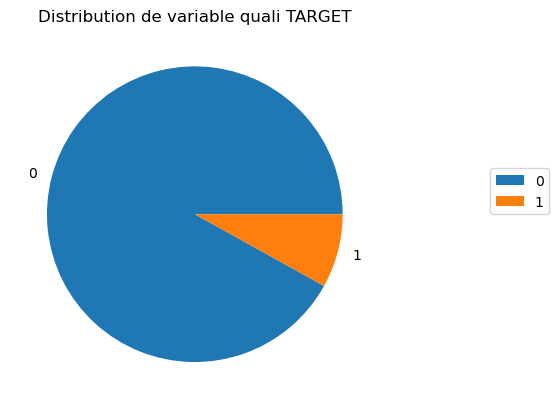

In [7]:
distrib_score(app_train, 'TARGET')

We clearly have an unbalanced data set. 

### 'application_train'

In [8]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [9]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [10]:
print(app_train['CODE_GENDER'].value_counts())

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64


In [11]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [12]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


In [28]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


In [6]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Count the number of colomns with more than 50% missing information
        mis_val_table_50 = mis_val_table_ren_columns[
            mis_val_table_ren_columns['% of Total Values'] > 50]
        less_than_50_columns = mis_val_table_50.index.to_list()
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        print("There is ", len(less_than_50_columns), 
              "columns with more than 50% missing values. \n")
        print(less_than_50_columns)
        display(mis_val_table_ren_columns)
        
        # Return the dataframe with missing information
        return less_than_50_columns

In [8]:
delete_columns = missing_values_table(app_train)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
There is  41 columns with more than 50% missing values. 

['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG', 'FONDKAPREMONT_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI', 'FLOORSMIN_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_AVG', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'ELEVATORS_AVG', 'WALLSMATERIAL_MODE', 'APARTMENTS_MODE', 'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'ENTRANCES_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'LIVINGAREA_AVG', 'HOUSETYPE_MODE']


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


We can't delete these columns, especially 'ext_source_1', which is almost anti-correleted to the target. We will impute with the median. 

In [21]:
def impute_numeric_nan(df): 
    
    numeric_columns = [col for col in df.columns if df[col].dtype != 'object']
    for num_col in numeric_columns : 
        strategy_median = df[num_col].median(skipna=True)
        df[num_col] = df[num_col].fillna(value=strategy_median)
    return df

In [4]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [5]:
# Preprocess application_train.csv
def application_train(num_rows = None, nan_as_category = False):
    # Read data
    df = pd.read_csv(path + 'application_train.csv', nrows= num_rows)
    print("Number of samples: {}".format(len(df)))

    # Remove 4 applications with XNA CODE_GENDER 
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Fill NaN in numerical columns
    df = impute_numeric_nan(df)
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    return df

In [9]:
df = application_train(num_rows=None, nan_as_category=True)
print(df.shape)

Number of samples: 307511
(307507, 260)


In [37]:
# Find correlations with the target and sort
correlations = df.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_ID_PUBLISH                   0.051457
DAYS_LAST_PHONE_CHANGE            0.055219
NAME_INCOME_TYPE_Working          0.057483
REGION_RATING_CLIENT              0.058901
REGION_RATING_CLIENT_W_CITY       0.060895
DAYS_EMPLOYED                     0.074957
DAYS_BIRTH                        0.078242
TARGET                            1.000000
NAME_CONTRACT_TYPE_nan                 NaN
NAME_INCOME_TYPE_nan                   NaN
NAME_EDUCATION_TYPE_nan                NaN
NAME_FAMILY_STATUS_nan                 NaN
NAME_HOUSING_TYPE_nan                  NaN
WEEKDAY_APPR_PROCESS_START_nan         NaN
ORGANIZATION_TYPE_nan                  NaN
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_2                           -0.160294
EXT_SOURCE_3                           -0.155899
EXT_SOURCE_1                           -0.098887
DAYS_EMPLOYED_PERC                     -0.067952
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER           

In [26]:
delete_columns = missing_values_table(df)

Your selected dataframe has 260 columns.
There are 2 columns that have missing values.
There is  0 columns with more than 50% missing values. 

[]


,Missing Values,% of Total Values
DAYS_EMPLOYED,55374,18.0
DAYS_EMPLOYED_PERC,55374,18.0


In [10]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

df_array = imputer.fit_transform(df)

df = pd.DataFrame(df_array, columns=df.columns)

### 'bureau' and 'bureau_balance'

In [11]:
bureau = pd.read_csv(path + 'bureau.csv')
print('bureau shape: ', bureau.shape)
display(bureau.head())

bb = pd.read_csv(path + 'bureau_balance.csv')
print('bureau_balance shape: ', bb.shape)
display(bb.head())

bureau shape:  (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


bureau_balance shape:  (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [35]:
# Number of unique classes in each object column
bureau.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

In [36]:
bb['STATUS'].nunique()

8

In [37]:
print(bureau['CREDIT_ACTIVE'].value_counts())

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64


In [51]:
temp = missing_values_table(bureau)
#temp = missing_values_table(bb)    # No missing values

Your selected dataframe has 17 columns.
There are 7 columns that have missing values.
There is  2 columns with more than 50% missing values. 

['AMT_ANNUITY', 'AMT_CREDIT_MAX_OVERDUE']


,Missing Values,% of Total Values
AMT_ANNUITY,1226791,71.5
AMT_CREDIT_MAX_OVERDUE,1124488,65.5
DAYS_ENDDATE_FACT,633653,36.9
AMT_CREDIT_SUM_LIMIT,591780,34.5
AMT_CREDIT_SUM_DEBT,257669,15.0
DAYS_CREDIT_ENDDATE,105553,6.1
AMT_CREDIT_SUM,13,0.0


Your selected dataframe has 3 columns.
There are 0 columns that have missing values.
There is  0 columns with more than 50% missing values. 

[]


,Missing Values,% of Total Values


In [43]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path + 'bureau.csv', nrows = num_rows)
    # Fill NaN in numerical columns
    bureau = impute_numeric_nan(bureau)
    
    bb = pd.read_csv(path + 'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [12]:
bureau = bureau_and_balance()
print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau
gc.collect()
print(df.shape)

Bureau df shape: (305811, 116)
(307507, 376)


In [10]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        #print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    corrs = pd.DataFrame(corrs)
    
    return corrs

In [45]:
correlations = target_corrs(df)
display(correlations[:20])

,0,1
0,EXT_SOURCE_2,-0.160294
1,EXT_SOURCE_3,-0.155899
2,EXT_SOURCE_1,-0.098887
3,BURO_MONTHS_BALANCE_SIZE_MEAN,-0.080193
4,DAYS_BIRTH,0.078242
5,DAYS_EMPLOYED,0.063366
6,REGION_RATING_CLIENT_W_CITY,0.060895
7,REGION_RATING_CLIENT,0.058901
8,DAYS_LAST_PHONE_CHANGE,0.055219
9,CODE_GENDER,-0.054710


In [46]:
delete_columns = missing_values_table(df)

Your selected dataframe has 376 columns.
There are 116 columns that have missing values.
There is  19 columns with more than 50% missing values. 

['ACTIVE_MONTHS_BALANCE_SIZE_MEAN', 'ACTIVE_MONTHS_BALANCE_MAX_MAX', 'ACTIVE_MONTHS_BALANCE_MIN_MIN', 'CLOSED_MONTHS_BALANCE_SIZE_MEAN', 'CLOSED_MONTHS_BALANCE_MAX_MAX', 'CLOSED_MONTHS_BALANCE_MIN_MIN', 'BURO_STATUS_2_MEAN_MEAN', 'BURO_MONTHS_BALANCE_SIZE_MEAN', 'BURO_STATUS_0_MEAN_MEAN', 'BURO_STATUS_1_MEAN_MEAN', 'BURO_STATUS_4_MEAN_MEAN', 'BURO_STATUS_3_MEAN_MEAN', 'BURO_MONTHS_BALANCE_MIN_MIN', 'BURO_STATUS_C_MEAN_MEAN', 'BURO_STATUS_X_MEAN_MEAN', 'BURO_STATUS_nan_MEAN_MEAN', 'BURO_MONTHS_BALANCE_MAX_MAX', 'BURO_STATUS_5_MEAN_MEAN', 'ACTIVE_DAYS_CREDIT_VAR']


,Missing Values,% of Total Values
ACTIVE_MONTHS_BALANCE_SIZE_MEAN,230988,75.1
ACTIVE_MONTHS_BALANCE_MAX_MAX,230988,75.1
ACTIVE_MONTHS_BALANCE_MIN_MIN,230988,75.1
CLOSED_MONTHS_BALANCE_SIZE_MEAN,226772,73.7
CLOSED_MONTHS_BALANCE_MAX_MAX,226772,73.7
...,...,...
BURO_CREDIT_CURRENCY_currency 3_MEAN,44020,14.3
BURO_CREDIT_CURRENCY_currency 2_MEAN,44020,14.3
BURO_CREDIT_CURRENCY_currency 1_MEAN,44020,14.3
BURO_CREDIT_ACTIVE_nan_MEAN,44020,14.3


In [7]:
def impute_nan (df) : 
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')

    df_array = imputer.fit_transform(df)

    df = pd.DataFrame(df_array, columns=df.columns)
    
    return df

In [13]:
df = impute_nan(df)

In [48]:
print(df.dtypes.value_counts())
print(df.isna().sum().sum())

float64    376
dtype: int64
0


### 'previous_application'

In [14]:
prev = pd.read_csv(path + 'previous_application.csv')
print('prev shape: ', prev.shape)
display(prev.head())

prev shape:  (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
days_feat = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
             'DAYS_LAST_DUE', 'DAYS_TERMINATION']
prev[days_feat].describe()

,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
count,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838
std,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729
min,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000
25%,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000
50%,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000
75%,365243.000000,-411.000000,129.000000,-74.000000,-44.000000
max,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000


In [41]:
# Number of unique classes in each object column
prev.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE              4
WEEKDAY_APPR_PROCESS_START      7
FLAG_LAST_APPL_PER_CONTRACT     2
NAME_CASH_LOAN_PURPOSE         25
NAME_CONTRACT_STATUS            4
NAME_PAYMENT_TYPE               4
CODE_REJECT_REASON              9
NAME_TYPE_SUITE                 7
NAME_CLIENT_TYPE                4
NAME_GOODS_CATEGORY            28
NAME_PORTFOLIO                  5
NAME_PRODUCT_TYPE               3
CHANNEL_TYPE                    8
NAME_SELLER_INDUSTRY           11
NAME_YIELD_GROUP                5
PRODUCT_COMBINATION            17
dtype: int64

In [42]:
print(prev['NAME_CONTRACT_STATUS'].value_counts())

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64


In [49]:
temp = missing_values_table(prev)

Your selected dataframe has 37 columns.
There are 16 columns that have missing values.
There is  4 columns with more than 50% missing values. 

['RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT']


,Missing Values,% of Total Values
RATE_INTEREST_PRIMARY,1664263,99.6
RATE_INTEREST_PRIVILEGED,1664263,99.6
AMT_DOWN_PAYMENT,895844,53.6
RATE_DOWN_PAYMENT,895844,53.6
NAME_TYPE_SUITE,820405,49.1
DAYS_FIRST_DRAWING,673065,40.3
DAYS_FIRST_DUE,673065,40.3
DAYS_LAST_DUE_1ST_VERSION,673065,40.3
DAYS_LAST_DUE,673065,40.3
DAYS_TERMINATION,673065,40.3


In [50]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path + 'previous_application.csv', nrows = num_rows)
    prev = prev.drop(prev[prev['AMT_CREDIT'].isnull()].index)
    prev = impute_numeric_nan(prev)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [15]:
prev = previous_applications()
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev
gc.collect()
print(df.shape)

Previous applications df shape: (338857, 237)
(307507, 613)


In [52]:
correlations = target_corrs(df)
display(correlations[:20])

,0,1
0,EXT_SOURCE_2,-0.160294
1,EXT_SOURCE_3,-0.155899
2,EXT_SOURCE_1,-0.098887
3,DAYS_BIRTH,0.078242
4,DAYS_EMPLOYED,0.063366
5,REGION_RATING_CLIENT_W_CITY,0.060895
6,REGION_RATING_CLIENT,0.058901
7,DAYS_LAST_PHONE_CHANGE,0.055219
8,CODE_GENDER,-0.054710
9,DAYS_ID_PUBLISH,0.051457


In [53]:
less_than_50_columns = missing_values_table(df)

Your selected dataframe has 613 columns.
There are 237 columns that have missing values.
There is  26 columns with more than 50% missing values. 

['REFUSED_CNT_PAYMENT_SUM', 'REFUSED_AMT_GOODS_PRICE_MIN', 'REFUSED_AMT_ANNUITY_MIN', 'REFUSED_AMT_ANNUITY_MAX', 'REFUSED_AMT_ANNUITY_MEAN', 'REFUSED_AMT_APPLICATION_MIN', 'REFUSED_AMT_APPLICATION_MAX', 'REFUSED_AMT_APPLICATION_MEAN', 'REFUSED_AMT_CREDIT_MIN', 'REFUSED_AMT_CREDIT_MEAN', 'REFUSED_AMT_DOWN_PAYMENT_MIN', 'REFUSED_AMT_DOWN_PAYMENT_MAX', 'REFUSED_AMT_DOWN_PAYMENT_MEAN', 'REFUSED_AMT_CREDIT_MAX', 'REFUSED_AMT_GOODS_PRICE_MAX', 'REFUSED_RATE_DOWN_PAYMENT_MAX', 'REFUSED_AMT_GOODS_PRICE_MEAN', 'REFUSED_DAYS_DECISION_MEAN', 'REFUSED_DAYS_DECISION_MAX', 'REFUSED_DAYS_DECISION_MIN', 'REFUSED_RATE_DOWN_PAYMENT_MEAN', 'REFUSED_CNT_PAYMENT_MEAN', 'REFUSED_RATE_DOWN_PAYMENT_MIN', 'REFUSED_HOUR_APPR_PROCESS_START_MEAN', 'REFUSED_HOUR_APPR_PROCESS_START_MAX', 'REFUSED_HOUR_APPR_PROCESS_START_MIN']


,Missing Values,% of Total Values
REFUSED_CNT_PAYMENT_SUM,207217,67.4
REFUSED_AMT_GOODS_PRICE_MIN,207217,67.4
REFUSED_AMT_ANNUITY_MIN,207217,67.4
REFUSED_AMT_ANNUITY_MAX,207217,67.4
REFUSED_AMT_ANNUITY_MEAN,207217,67.4
...,...,...
PREV_CODE_REJECT_REASON_SYSTEM_MEAN,16454,5.4
PREV_CODE_REJECT_REASON_VERIF_MEAN,16454,5.4
PREV_CODE_REJECT_REASON_XAP_MEAN,16454,5.4
PREV_CODE_REJECT_REASON_XNA_MEAN,16454,5.4


In [16]:
df = impute_nan(df)

In [57]:
print(df.dtypes.value_counts())
print(df.isna().sum().sum())

float64    613
dtype: int64
0


### 'POS_CASH_balance'

In [17]:
pos = pd.read_csv(path + 'POS_CASH_balance.csv')
print('pos shape: ', pos.shape)
display(pos.head())

pos shape:  (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [40]:
# Number of unique classes in each object column
pos.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_STATUS    9
dtype: int64

In [43]:
display(pos.groupby('SK_ID_CURR').size().describe())

count    337252.000000
mean         29.655445
std          24.531971
min           1.000000
25%          12.000000
50%          22.000000
75%          39.000000
max         295.000000
dtype: float64

In [44]:
temp = missing_values_table(pos)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.
There is  0 columns with more than 50% missing values. 

[]


,Missing Values,% of Total Values
CNT_INSTALMENT_FUTURE,26087,0.3
CNT_INSTALMENT,26071,0.3


In [59]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path + 'POS_CASH_balance.csv', nrows = num_rows)
    pos = impute_numeric_nan(pos)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [18]:
pos = pos_cash()
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos
gc.collect()

Pos-cash balance df shape: (337252, 18)


0

In [61]:
correlations = target_corrs(df)
display(correlations[:20])

,0,1
0,EXT_SOURCE_2,-0.160294
1,EXT_SOURCE_3,-0.155899
2,EXT_SOURCE_1,-0.098887
3,DAYS_BIRTH,0.078242
4,DAYS_EMPLOYED,0.063366
5,REGION_RATING_CLIENT_W_CITY,0.060895
6,REGION_RATING_CLIENT,0.058901
7,DAYS_LAST_PHONE_CHANGE,0.055219
8,CODE_GENDER,-0.054710
9,DAYS_ID_PUBLISH,0.051457


In [62]:
less_than_50_columns = missing_values_table(df)

Your selected dataframe has 631 columns.
There are 18 columns that have missing values.
There is  0 columns with more than 50% missing values. 

[]


,Missing Values,% of Total Values
POS_MONTHS_BALANCE_MAX,18067,5.9
POS_MONTHS_BALANCE_MEAN,18067,5.9
POS_NAME_CONTRACT_STATUS_nan_MEAN,18067,5.9
POS_NAME_CONTRACT_STATUS_XNA_MEAN,18067,5.9
POS_NAME_CONTRACT_STATUS_Signed_MEAN,18067,5.9
POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,18067,5.9
POS_NAME_CONTRACT_STATUS_Demand_MEAN,18067,5.9
POS_NAME_CONTRACT_STATUS_Completed_MEAN,18067,5.9
POS_NAME_CONTRACT_STATUS_Canceled_MEAN,18067,5.9
POS_NAME_CONTRACT_STATUS_Approved_MEAN,18067,5.9


In [19]:
df = impute_nan(df)

In [20]:
print(df.dtypes.value_counts())
print(df.isna().sum().sum())

float64    631
dtype: int64
0


### 'installments_payments'

In [21]:
ins = pd.read_csv(path + 'installments_payments.csv')
print('ins shape: ', ins.shape)
display(ins.head())

ins shape:  (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [25]:
ins.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

In [54]:
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
display(ins[['PAYMENT_DIFF', 'DPD', 'DBD']].describe())

,PAYMENT_DIFF,DPD,DBD
count,1.360250e+07,1.360540e+07,1.360540e+07
mean,-1.871538e+02,1.033764e+00,9.819293e+00
std,1.910673e+04,2.077770e+01,1.414741e+01
min,-2.630909e+06,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,6.000000e+00
75%,0.000000e+00,0.000000e+00,1.400000e+01
max,2.424726e+06,2.884000e+03,3.189000e+03


In [55]:
display(ins.groupby('SK_ID_CURR').size().describe())

count    339587.000000
mean         40.064552
std          41.053343
min           1.000000
25%          12.000000
50%          25.000000
75%          51.000000
max         372.000000
dtype: float64

In [63]:
temp = missing_values_table(ins)

Your selected dataframe has 12 columns.
There are 4 columns that have missing values.
There is  0 columns with more than 50% missing values. 

[]


,Missing Values,% of Total Values
PAYMENT_PERC,2907,0.0
DAYS_ENTRY_PAYMENT,2905,0.0
AMT_PAYMENT,2905,0.0
PAYMENT_DIFF,2905,0.0


In [10]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path + 'installments_payments.csv', nrows = num_rows)

    # Difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Fill NaN with median strategy
    ins = impute_numeric_nan(ins)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }

    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [22]:
ins = installments_payments()
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins
gc.collect()

Installments payments df shape: (339587, 22)


0

In [23]:
correlations = target_corrs(df)
display(correlations[:20])

,0,1
0,EXT_SOURCE_2,-0.160294
1,EXT_SOURCE_3,-0.155899
2,EXT_SOURCE_1,-0.098887
3,DAYS_BIRTH,0.078242
4,DAYS_EMPLOYED,0.063366
5,REGION_RATING_CLIENT_W_CITY,0.060895
6,REGION_RATING_CLIENT,0.058901
7,DAYS_LAST_PHONE_CHANGE,0.055219
8,CODE_GENDER,-0.054710
9,PREV_DAYS_DECISION_MIN,0.052142


In [24]:
less_than_50_columns = missing_values_table(df)

Your selected dataframe has 653 columns.
There are 22 columns that have missing values.
There is  0 columns with more than 50% missing values. 

[]


,Missing Values,% of Total Values
INSTAL_PAYMENT_DIFF_VAR,16560,5.4
INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,15868,5.2
INSTAL_AMT_INSTALMENT_MEAN,15868,5.2
INSTAL_DAYS_ENTRY_PAYMENT_SUM,15868,5.2
INSTAL_DAYS_ENTRY_PAYMENT_MEAN,15868,5.2
INSTAL_DAYS_ENTRY_PAYMENT_MAX,15868,5.2
INSTAL_AMT_PAYMENT_SUM,15868,5.2
INSTAL_AMT_PAYMENT_MEAN,15868,5.2
INSTAL_AMT_PAYMENT_MAX,15868,5.2
INSTAL_AMT_PAYMENT_MIN,15868,5.2


In [25]:
df = impute_nan(df)

In [26]:
print(df.dtypes.value_counts())
print(df.isna().sum().sum())

float64    653
dtype: int64
0


### 'credit_card_balance'

In [27]:
cc = pd.read_csv(path + 'credit_card_balance.csv')
print('cc shape: ', cc.shape)
display(cc.head())

cc shape:  (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [25]:
cc.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_STATUS    7
dtype: int64

In [26]:
display(cc.groupby('SK_ID_CURR').size().describe())

count    103558.000000
mean         37.083683
std          33.483627
min           1.000000
25%          10.000000
50%          22.000000
75%          75.000000
max         192.000000
dtype: float64

In [27]:
temp = missing_values_table(cc)

Your selected dataframe has 23 columns.
There are 9 columns that have missing values.
There is  0 columns with more than 50% missing values. 

[]


,Missing Values,% of Total Values
AMT_PAYMENT_CURRENT,767988,20.0
AMT_DRAWINGS_ATM_CURRENT,749816,19.5
AMT_DRAWINGS_OTHER_CURRENT,749816,19.5
AMT_DRAWINGS_POS_CURRENT,749816,19.5
CNT_DRAWINGS_ATM_CURRENT,749816,19.5
CNT_DRAWINGS_OTHER_CURRENT,749816,19.5
CNT_DRAWINGS_POS_CURRENT,749816,19.5
AMT_INST_MIN_REGULARITY,305236,7.9
CNT_INSTALMENT_MATURE_CUM,305236,7.9


In [28]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path + 'credit_card_balance.csv', nrows = num_rows)
    cc = impute_numeric_nan(cc)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [29]:
cc = credit_card_balance()
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc
gc.collect()

Credit card balance df shape: (103558, 141)


0

In [30]:
print("Final DataFrame shape: ", df.shape)

Final DataFrame shape:  (307507, 794)


In [31]:
correlations = target_corrs(df)
display(correlations[:20])

,0,1
0,EXT_SOURCE_2,-0.160294
1,EXT_SOURCE_3,-0.155899
2,EXT_SOURCE_1,-0.098887
3,BURO_DAYS_CREDIT_MEAN,0.082081
4,DAYS_BIRTH,0.078242
5,DAYS_EMPLOYED,0.063366
6,REGION_RATING_CLIENT_W_CITY,0.060895
7,REGION_RATING_CLIENT,0.058901
8,DAYS_LAST_PHONE_CHANGE,0.055219
9,CODE_GENDER,-0.054710


In [32]:
less_than_50_columns = missing_values_table(df)

Your selected dataframe has 794 columns.
There are 141 columns that have missing values.
There is  141 columns with more than 50% missing values. 

['CC_AMT_INST_MIN_REGULARITY_VAR', 'CC_NAME_CONTRACT_STATUS_Refused_VAR', 'CC_NAME_CONTRACT_STATUS_Demand_VAR', 'CC_AMT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_NAME_CONTRACT_STATUS_Completed_VAR', 'CC_AMT_DRAWINGS_POS_CURRENT_VAR', 'CC_NAME_CONTRACT_STATUS_Approved_VAR', 'CC_AMT_PAYMENT_CURRENT_VAR', 'CC_NAME_CONTRACT_STATUS_Active_VAR', 'CC_AMT_PAYMENT_TOTAL_CURRENT_VAR', 'CC_SK_DPD_DEF_VAR', 'CC_AMT_RECEIVABLE_PRINCIPAL_VAR', 'CC_SK_DPD_VAR', 'CC_AMT_RECIVABLE_VAR', 'CC_AMT_TOTAL_RECEIVABLE_VAR', 'CC_CNT_INSTALMENT_MATURE_CUM_VAR', 'CC_CNT_DRAWINGS_ATM_CURRENT_VAR', 'CC_CNT_DRAWINGS_POS_CURRENT_VAR', 'CC_CNT_DRAWINGS_CURRENT_VAR', 'CC_AMT_DRAWINGS_CURRENT_VAR', 'CC_CNT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_AMT_CREDIT_LIMIT_ACTUAL_VAR', 'CC_AMT_DRAWINGS_ATM_CURRENT_VAR', 'CC_AMT_BALANCE_VAR', 'CC_NAME_CONTRACT_STATUS_nan_VAR', 'CC_NAME_CONTRACT_STATUS

,Missing Values,% of Total Values
CC_AMT_INST_MIN_REGULARITY_VAR,221234,71.9
CC_NAME_CONTRACT_STATUS_Refused_VAR,221234,71.9
CC_NAME_CONTRACT_STATUS_Demand_VAR,221234,71.9
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,221234,71.9
CC_NAME_CONTRACT_STATUS_Completed_VAR,221234,71.9
...,...,...
CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,220602,71.7
CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,220602,71.7
CC_AMT_PAYMENT_CURRENT_SUM,220602,71.7
CC_AMT_PAYMENT_CURRENT_MEAN,220602,71.7


In [33]:
df = impute_nan(df)

In [34]:
print(df.dtypes.value_counts())
print(df.isna().sum().sum())

float64    794
dtype: int64
0


## Export the data
### Import the aggregated data

In [35]:
df.to_csv("Docs_projet7/df_explore.csv", index=False)

In [9]:
df = pd.read_csv("Docs_projet7/df_explore.csv")
print(df.shape)
display(df.head())

(307507, 794)


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002.0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
1,100003.0,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
2,100004.0,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
3,100006.0,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007.0,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0


## Exploratory Analysis

In [31]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)
    
    plt.show()

The correlation between EXT_SOURCE_1 and the TARGET is -0.0989
Median value for loan that was not repaid = 0.5060
Median value for loan that was repaid =     0.5060


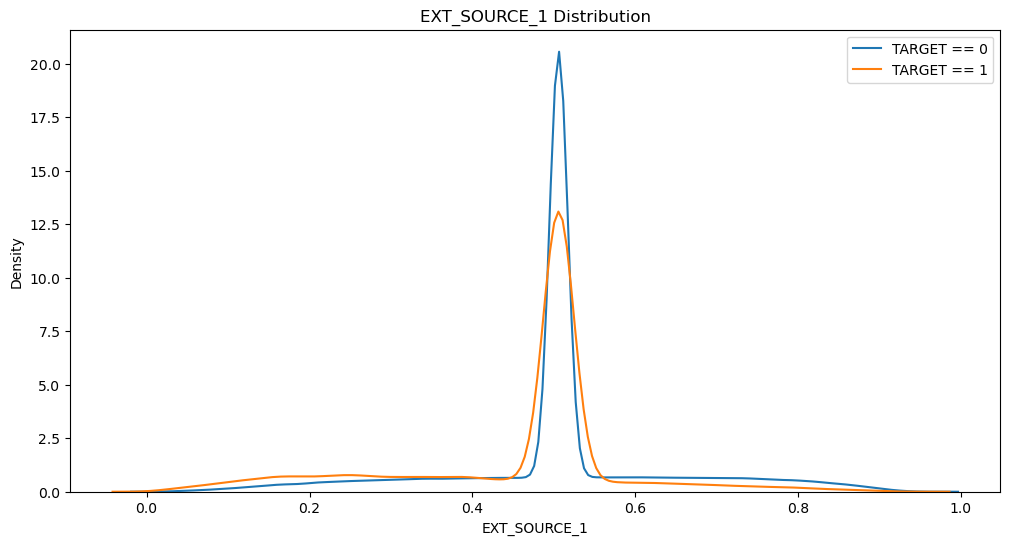

The correlation between EXT_SOURCE_2 and the TARGET is -0.1603
Median value for loan that was not repaid = 0.4411
Median value for loan that was repaid =     0.5734


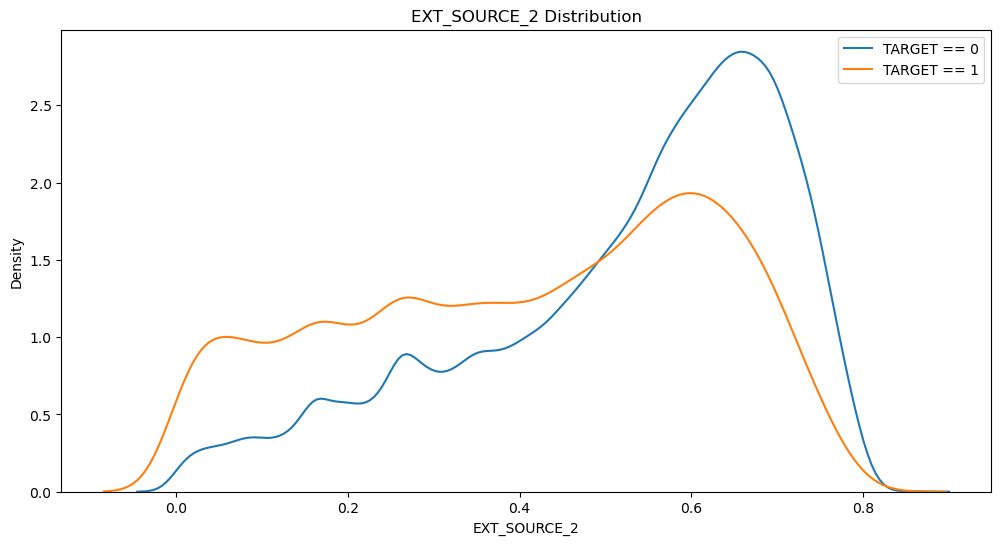

The correlation between EXT_SOURCE_3 and the TARGET is -0.1559
Median value for loan that was not repaid = 0.4758
Median value for loan that was repaid =     0.5353


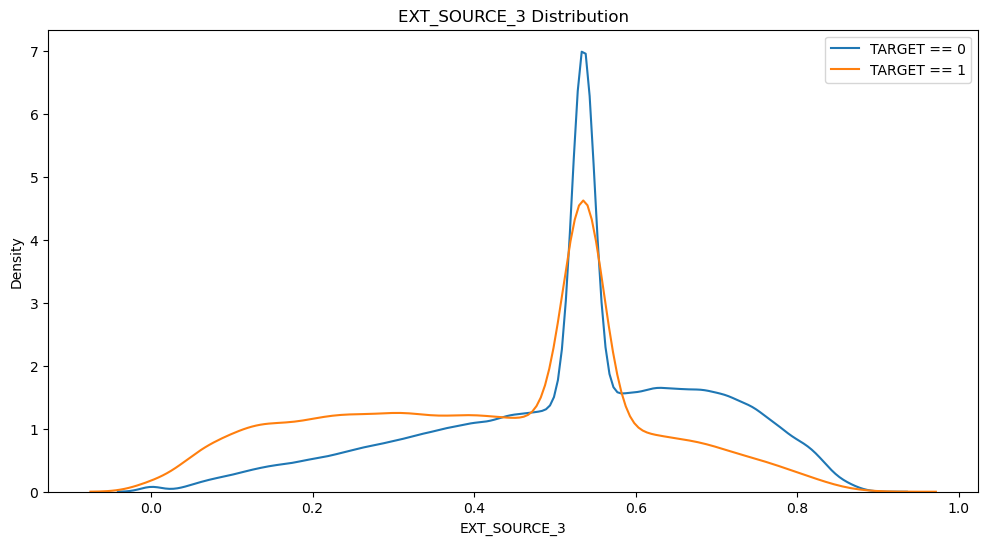

In [32]:
# iterate through the sources
for source in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
    
    kde_target(source, df)

The correlation between BURO_DAYS_CREDIT_MEAN and the TARGET is 0.0821
Median value for loan that was not repaid = -1006.3333
Median value for loan that was repaid =     -1050.5714


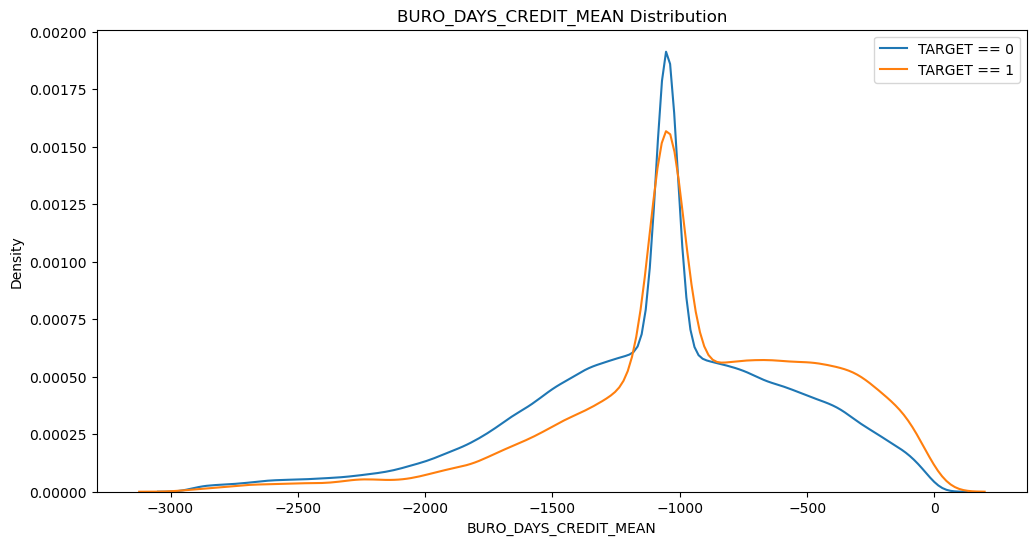

The correlation between DAYS_BIRTH and the TARGET is 0.0782
Median value for loan that was not repaid = -14282.0000
Median value for loan that was repaid =     -15877.0000


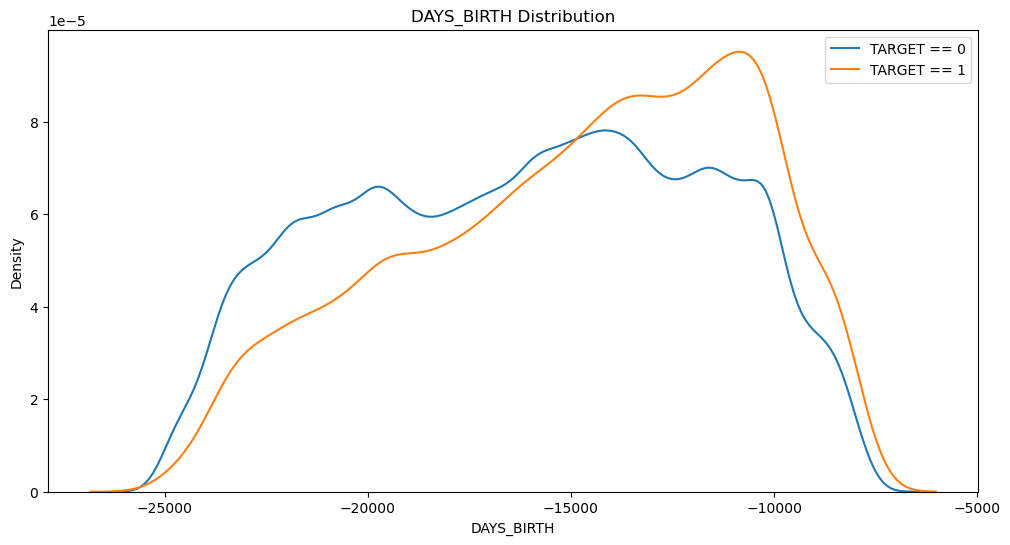

The correlation between DAYS_EMPLOYED and the TARGET is 0.0634
Median value for loan that was not repaid = -1458.0000
Median value for loan that was repaid =     -1648.0000


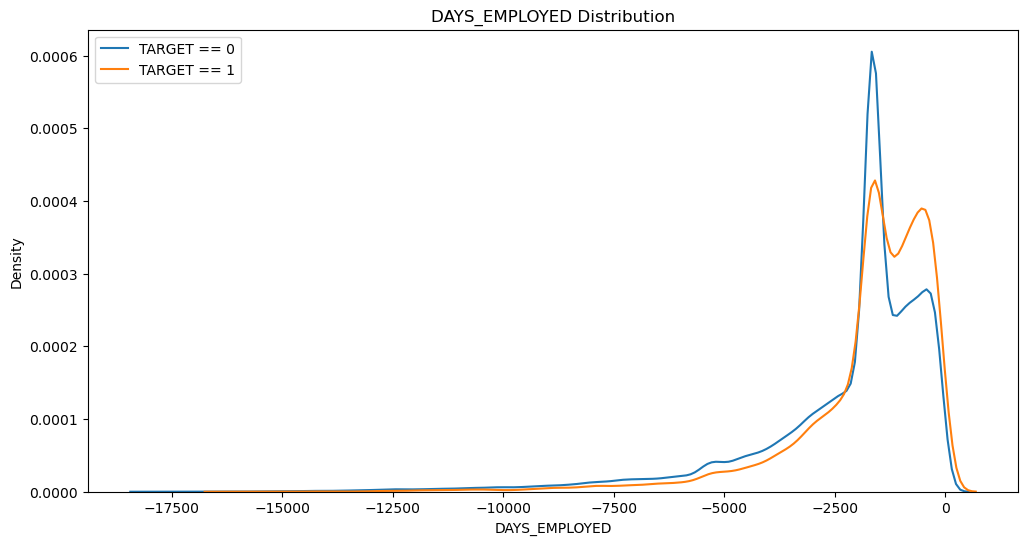

In [33]:
# iterate through the sources
for source in ['BURO_DAYS_CREDIT_MEAN', 'DAYS_BIRTH', 'DAYS_EMPLOYED']:
    
    kde_target(source, df)

The correlation between PREV_DAYS_DECISION_MIN and the TARGET is 0.0521
Median value for loan that was not repaid = -1282.0000
Median value for loan that was repaid =     -1502.0000


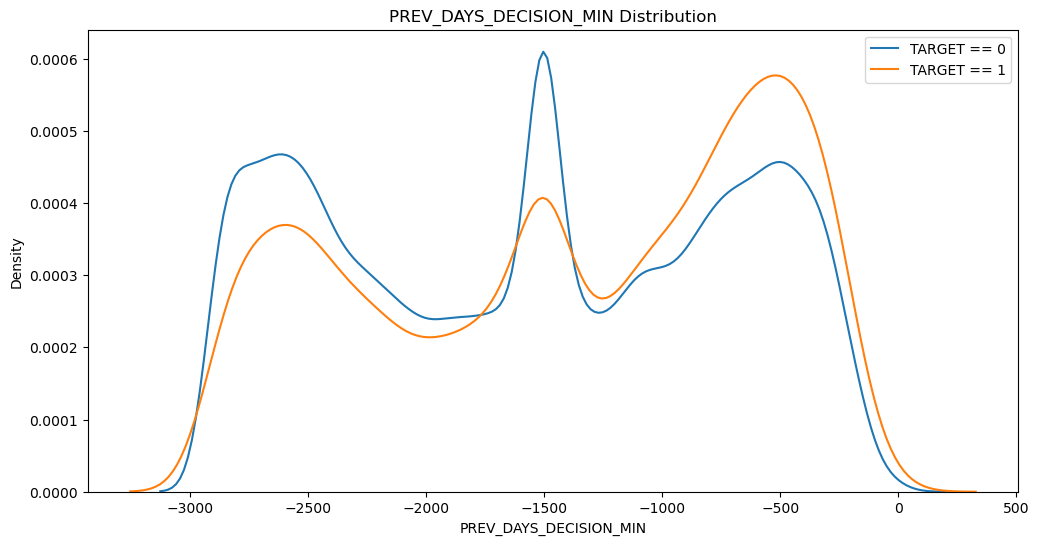

The correlation between PREV_DAYS_DECISION_MEAN and the TARGET is 0.0449
Median value for loan that was not repaid = -703.0000
Median value for loan that was repaid =     -789.0000


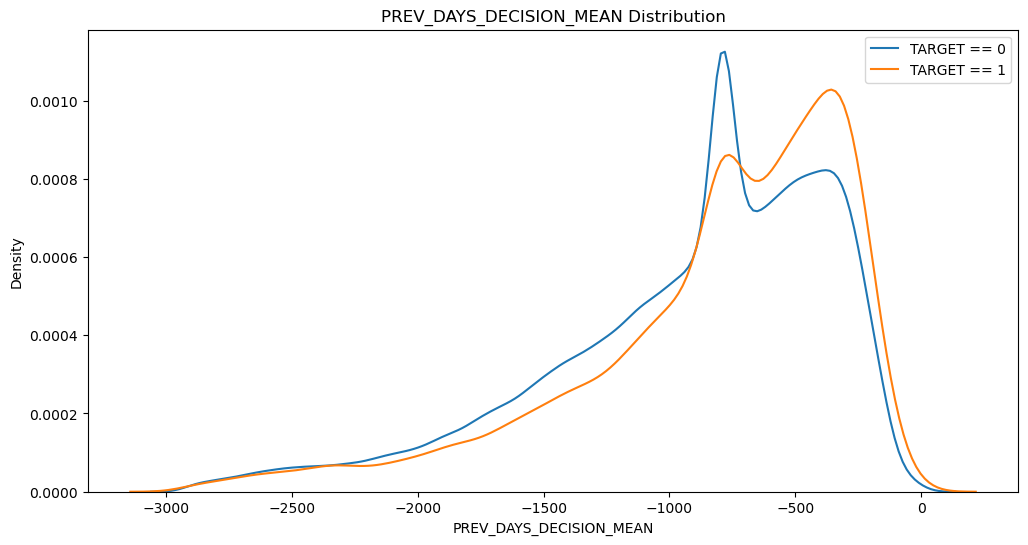

The correlation between PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN and the TARGET is 0.0400
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


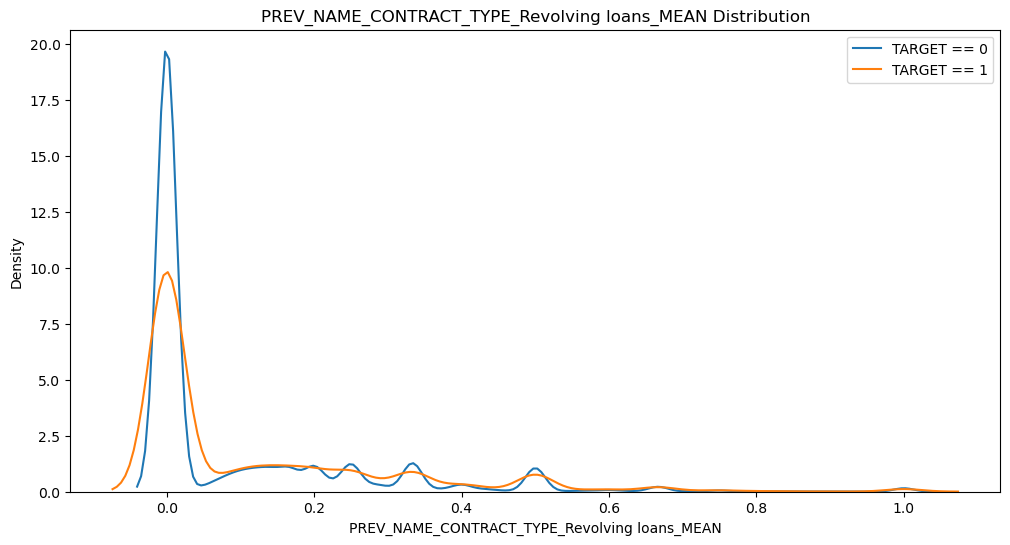

In [34]:
# iterate through the sources
for source in ['PREV_DAYS_DECISION_MIN', 'PREV_DAYS_DECISION_MEAN', 'PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN']:
    
    kde_target(source, df)


## Pre Processing the data

In [12]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [36]:
# Preprocess application.csv
def application(df, num_rows = None, nan_as_category = True):
    # Read data
    print("Number of samples: {}".format(len(df)))

    # Remove 4 applications with XNA CODE_GENDER 
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Fill NaN in numerical columns
    df = impute_numeric_nan(df)
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    return df

In [38]:
def make_data (df): 
    
    with timer("Process application"):
        df = application(df)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance()
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
        df = impute_nan(df)
    with timer("Process previous_applications"):
        prev = previous_applications()
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
        df = impute_nan(df)
    with timer("Process POS-CASH balance"):
        pos = pos_cash()
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
        df = impute_nan(df)
    with timer("Process installments payments"):
        ins = installments_payments()
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
        df = impute_nan(df)
    with timer("Process credit card balance"):
        cc = credit_card_balance()
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        df = impute_nan(df)
    
    return df

## Train and Test Data

In [7]:
def split_the_data (debug= False):
    df_raw = pd.read_csv(path + 'application_train.csv')
    if debug : 
        df = df_raw.sample(12000)
    else : 
        df = df_raw
    del df_raw
    gc.collect()
    app_train, app_test = train_test_split(df, test_size=0.2, random_state=SEED)

    df_train = make_data(app_train)
    df_test = make_data(app_test)

    print("\nTrain set shape: ", df_train.shape)
    print("\nTest set shape: ", df_test.shape)
    
    return df_train, df_test

In [52]:
df_train, df_test = split_the_data (debug=True)

Number of samples: 9600
Process application - done in 0s
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 9s
Previous applications df shape: (338857, 237)
Process previous_applications - done in 12s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 7s
Installments payments df shape: (339587, 22)
Process installments payments - done in 16s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 10s
Number of samples: 2400
Process application - done in 0s
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 9s
Previous applications df shape: (338857, 237)
Process previous_applications - done in 11s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 7s
Installments payments df shape: (339587, 22)
Process installments payments - done in 15s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 10s

Train set shape:  (9599, 788)

Test set sha

In [18]:
print(df_train.shape)

(9600, 656)


## Modelisation  mode debug = True

In [12]:
experiment_id = mlflow.create_experiment(name="test on sample") 

In [13]:
print(experiment_id)

189439140820192523


In [9]:
df_sample = pd.read_csv("Docs_projet7/df_explore.csv", nrows = 12000)
print(df_sample.shape)
display(df_sample.head())

(12000, 794)


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002.0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
1,100003.0,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
2,100004.0,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
3,100006.0,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007.0,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0


In [65]:
#df_sample = df.sample(12000)
#print(df_sample.shape)
#df_train, df_test = train_test_split(df_sample, test_size=0.2, random_state=SEED)

feats = [f for f in df_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X_train = df_train[feats]
y_train = df_train['TARGET']
# Align the training and testing data, keep only columns present in both dataframes
X_train, X_test = X_train.align(X_test, join = 'inner', axis = 1)
y_test = df_test['TARGET']
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9599, 779) (2400, 779) (9599,) (2400,)


### Dummy

In [66]:
mlflow.end_run()
mlflow.start_run(experiment_id=189439140820192523, run_name="Dummy")
dummy_clf = DummyClassifier(strategy="prior")
dummy_clf.fit(X_train, y_train)


DummyClassifier()

In [67]:
y_pred = dummy_clf.predict_proba(X_test)
print(y_pred.shape)
y_pred_1 = y_pred[:, 1]
print(y_pred_1.shape)

(2400, 2)
(2400,)


In [8]:
def score_function (y_true, y_pred) :

    # calculate inputs for the roc curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # plot roc curve
    plt.plot(fpr, tpr, marker='.')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig('roc_curve.png')
    plt.show()
    
    mlflow.log_artifact("roc_curve.png")

    # calculate and print AUROC
    roc_auc = roc_auc_score(y_true, y_pred)
    mlflow.log_metric('Test AUC_score', roc_auc)
    print('AUROC: %.3f' % roc_auc)

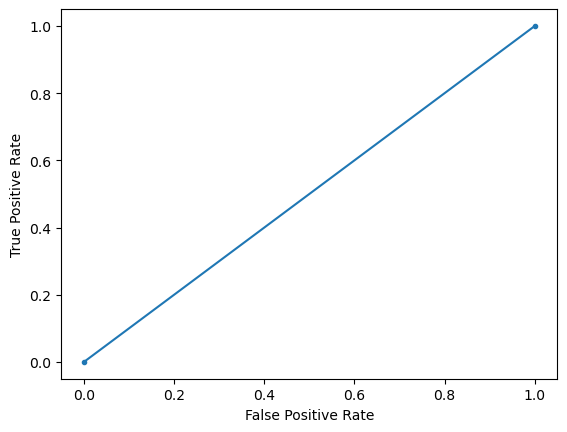

AUROC: 0.500


In [60]:
score_function(y_test, y_pred_1)

In [68]:
mlflow.end_run()

### Logistic Regression

In [12]:
df_sample = df.sample(12000)
#print(df_sample.shape)
df_train, df_test = train_test_split(df_sample, test_size=0.2, random_state=SEED)

feats = [f for f in df_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X_train = df_train[feats]
y_train = df_train['TARGET']
X_train, X_test = X_train.align(X_test, join = 'inner', axis = 1)
y_test = df_test['TARGET']
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9600, 792) (2400, 792) (9600,) (2400,)


In [69]:
mlflow.end_run()
mlflow.start_run(experiment_id=189439140820192523, run_name="Log_Reg")

<ActiveRun: >

In [70]:


param_grid = {
              'undersample__sampling_strategy' : [0.1, 0.2, 0.3], 
              'oversample__sampling_strategy' : [0.4, 0.5, 0.6], 
              'classifier__lr__C' : [0.0001, 0.001]
             }
scaler = MinMaxScaler(feature_range = (0, 1))
lr = LogisticRegression(class_weight='balanced')
clf = Pipeline([('scaler', scaler), ('lr', lr)])

mlflow.log_params(param_grid)
    
under = RandomUnderSampler()
over = SMOTE()
    
pipe = Pipeline([('undersample', under), ('oversample', over), ('classifier', clf)], 
                    verbose=False)

# define cross-validation
cv = StratifiedKFold(n_splits=5)

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=cv, scoring='roc_auc')
grid.fit(X_train, y_train)

mlflow.log_metric('Train AUC_score', grid.best_score_)

In [71]:
y_score = grid.predict_proba(X_test)
print(y_score.shape)

(2400, 2)


In [72]:
y_pred = y_score[:,1]
print(y_pred.shape)

(2400,)


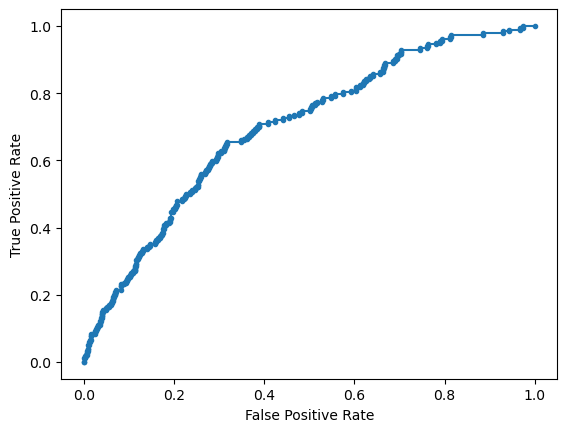

AUROC: 0.697


In [73]:
score_function(y_test, y_pred)

In [74]:
mlflow.end_run()

### LightGBM

In [9]:
import re

def debug_json_characters (df) : 
    new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df.columns}
    df = df.rename(columns=new_names)
    return df

In [76]:
X_train = debug_json_characters(X_train)

In [77]:
mlflow.start_run(experiment_id=189439140820192523, run_name="LightGBM", nested=True)
param_grid = {'undersample__sampling_strategy' : [0.2, 0.3], 
              'oversample__sampling_strategy' : [0.5, 0.6],
              #'classifier__num_leaves' : [31, 34, 36], 
              #'classifier__max_depth' : [6, 8, 10], 
              #'classifier__learning_rate' : [0.005, 0.02, 0.05]
                     }
clf = LGBMClassifier(
                            n_estimators=10000,
                            learning_rate=0.02,
                            num_leaves=34,
                            colsample_bytree=0.9497036,
                            subsample=0.8715623,
                            max_depth=8,
                            reg_alpha=0.041545473,
                            reg_lambda=0.0735294,
                            min_split_gain=0.0222415,
                            min_child_weight=39.3259775,
                            #nthread=4,
                            #silent=-1,
                            verbose=-1, )

mlflow.log_params(param_grid)
    
under = RandomUnderSampler()
over = SMOTE()
    
pipe = Pipeline([('undersample', under), ('oversample', over), ('classifier', clf)], 
                    verbose=False)

# define cross-validation
cv = StratifiedKFold(n_splits=5)

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=cv, scoring='roc_auc')
grid.fit(X_train, y_train)

mlflow.log_metric('Train AUC_score', grid.best_score_)

In [78]:
print(grid.best_params_)

{'oversample__sampling_strategy': 0.5, 'undersample__sampling_strategy': 0.2}


In [121]:
y_score = grid.predict_proba(X_test)
print(y_score.shape)

y_pred = y_score[:,1]
print(y_pred.shape)

(2400, 2)
(2400,)


In [122]:
print(np.sort(y_pred))

[1.71966657e-04 1.76412706e-04 1.78985816e-04 ... 9.68724335e-01
 9.74457373e-01 9.83162616e-01]


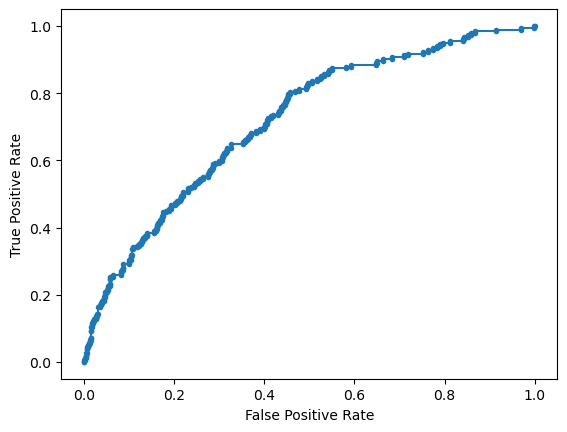

AUROC: 0.718


In [80]:
score_function(y_test, y_pred)

## Score métier

In [19]:
def score_metier (y_true, y_pred, seuil=0.5) : 
    
    eval_name = 'score_metier'
    
    y_predict = y_pred.copy()
    #seuil = 0.5
    y_predict[y_predict >= seuil] = 1
    y_predict[y_predict < seuil] = 0
    
    #s_pred = pd.Series(y_predict)
    #print("seuil : ", seuil, "score : ", s_pred.value_counts())
    
    cm = confusion_matrix(y_true, y_predict)
    fp = cm[0,1]
    fn = cm[1,0]
    tp = cm[0,0]
    tn = cm[1,1]
    eval_result =  (fp + 10 * fn) / (fp+tp + 10*(fn+tn))
    
    is_higher_better = False
    
    return eval_name, eval_result, is_higher_better

In [129]:
liste_seuil = np.arange(0.01, 1, 0.01)
#print(liste_seuil)

liste_score = []
for seuil in liste_seuil : 
    n, result, b = score_metier(y_test, y_pred, seuil=seuil)
    liste_score.append(result)

df_seuil = pd.DataFrame({'seuil' : liste_seuil, 'score' : liste_score}, columns=['seuil', 'score'])    
display(df_seuil.sort_values('score', ascending=True))

,seuil,score
7,0.08,0.341506
3,0.04,0.342496
8,0.09,0.343487
6,0.07,0.345220
14,0.15,0.346954
...,...,...
94,0.95,0.449232
95,0.96,0.449232
93,0.94,0.449480
98,0.99,0.450718


Le seuil optimal pour déterminer si la target est 0 ou 1, à partir de la probabilité d'être 1, est 0.08. 

## Optimisation des hyperparamètres du modèle, mode debug = False

In [130]:
experiment_id = mlflow.create_experiment(name="Essais de modélisation") 
print(experiment_id)

435416204203622602


In [10]:
experiment_id = 435416204203622602

In [11]:
df_train, df_test = split_the_data (debug=False)

feats = [f for f in df_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X_train = df_train[feats]
y_train = df_train['TARGET']
# Align the training and testing data, keep only columns present in both dataframes

X_train, X_test = X_train.align(df_test, join = 'inner', axis = 1)
y_test = df_test['TARGET']
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Number of samples: 246008
Process application - done in 2s
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 15s
Previous applications df shape: (338857, 237)
Process previous_applications - done in 22s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 17s
Installments payments df shape: (339587, 22)
Process installments payments - done in 26s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 25s
Number of samples: 61503
Process application - done in 0s
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 10s
Previous applications df shape: (338857, 237)
Process previous_applications - done in 13s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 8s
Installments payments df shape: (339587, 22)
Process installments payments - done in 17s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 13s

Train set shape:  (246004, 794)

Test

NameError: name 'X_test' is not defined

In [12]:
X_train, X_test = X_train.align(df_test, join = 'inner', axis = 1)
y_test = df_test['TARGET']
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(246004, 790) (61503, 790) (246004,) (61503,)


### Dummy

Training Dummy - done in 0s
(61503,)
Predict with Dummy - done in 0s


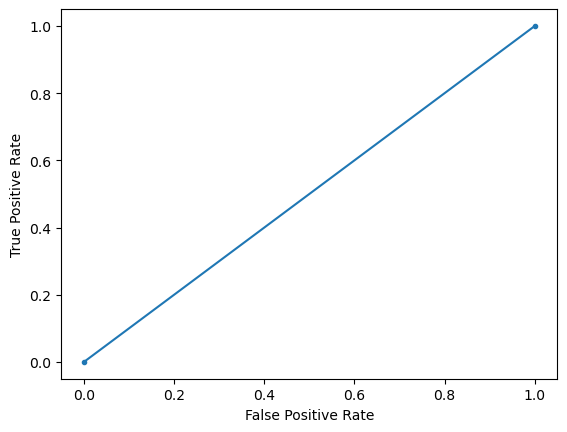

AUROC: 0.500


In [16]:
mlflow.end_run()
mlflow.start_run(experiment_id=experiment_id, run_name="Dummy")

with timer("Training Dummy"):
    dummy_clf = DummyClassifier(strategy="prior")
    dummy_clf.fit(X_train, y_train)

with timer("Predict with Dummy"):
    y_score = dummy_clf.predict_proba(X_test)
    #print(y_score.shape)
    y_pred = y_score[:, 1]
    print(y_pred.shape)

score_function(y_test, y_pred)
mlflow.end_run()

### Logistic Regression

Training Log_Reg - done in 1037s
{'classifier__lr__C': 0.001, 'oversample__sampling_strategy': 0.6, 'undersample__sampling_strategy': 0.1}
(61503,)
Predict with Logistic Regression - done in 0s


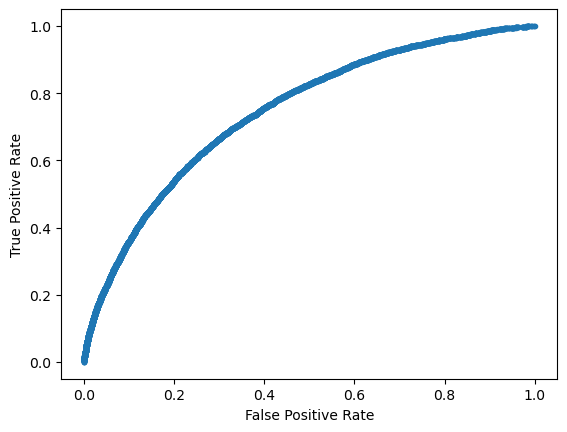

AUROC: 0.746


In [17]:
mlflow.end_run()
mlflow.start_run(experiment_id=experiment_id, run_name="Log_Reg")

with timer("Training Log_Reg"):
    param_grid = {
              'undersample__sampling_strategy' : [0.1, 0.2, 0.3], 
              'oversample__sampling_strategy' : [0.4, 0.5, 0.6], 
              'classifier__lr__C' : [0.0001, 0.001]
             }
    scaler = MinMaxScaler(feature_range = (0, 1))
    lr = LogisticRegression(class_weight='balanced')
    clf = Pipeline([('scaler', scaler), ('lr', lr)])

    mlflow.log_params(param_grid)
    
    under = RandomUnderSampler()
    over = SMOTE()
    
    pipe = Pipeline([('undersample', under), ('oversample', over), ('classifier', clf)], 
                    verbose=False)

    # define cross-validation
    cv = StratifiedKFold(n_splits=5)

    grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=cv, scoring='roc_auc')
    grid.fit(X_train, y_train)

mlflow.log_metric('Train AUC_score', grid.best_score_)
print(grid.best_params_)

with timer("Predict with Logistic Regression"):
    y_score = grid.predict_proba(X_test)
    y_pred = y_score[:,1]
    print(y_pred.shape)

score_function(y_test, y_pred)
mlflow.end_run()

### LightGBM

[Pipeline] ....... (step 1 of 3) Processing undersample, total=   1.0s
[Pipeline] ........ (step 2 of 3) Processing oversample, total=   3.3s
[Pipeline] ........ (step 3 of 3) Processing classifier, total= 8.5min
[Pipeline] ....... (step 1 of 3) Processing undersample, total=   0.9s
[Pipeline] ........ (step 2 of 3) Processing oversample, total=   3.4s
[Pipeline] ........ (step 3 of 3) Processing classifier, total= 8.6min
[Pipeline] ....... (step 1 of 3) Processing undersample, total=   0.9s
[Pipeline] ........ (step 2 of 3) Processing oversample, total=   3.6s
[Pipeline] ........ (step 3 of 3) Processing classifier, total= 8.5min
[Pipeline] ....... (step 1 of 3) Processing undersample, total=   0.9s
[Pipeline] ........ (step 2 of 3) Processing oversample, total=   3.6s
[Pipeline] ........ (step 3 of 3) Processing classifier, total= 8.7min
[Pipeline] ....... (step 1 of 3) Processing undersample, total=   0.9s
[Pipeline] ........ (step 2 of 3) Processing oversample, total=   3.5s
[Pipel

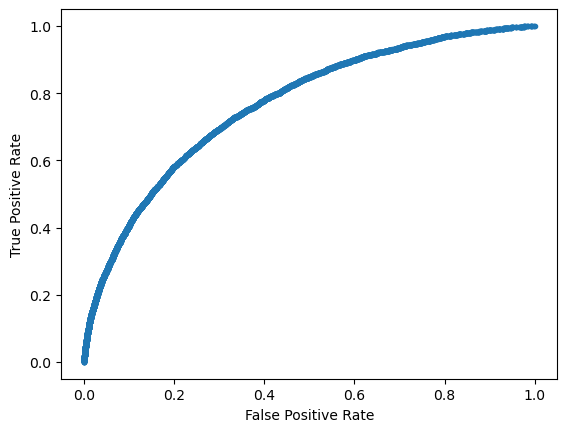

AUROC: 0.766


In [18]:
mlflow.end_run()
mlflow.start_run(experiment_id=experiment_id, run_name="LightGBM_Smote")

X_train = debug_json_characters(X_train)

with timer("Training LightGBM model"):
    param_grid = {
              #'undersample__sampling_strategy' : [0.1, 0.2, 0.3], 
              'oversample__sampling_strategy' : [0.4, 0.5, 0.6],
              #'classifier__num_leaves' : [31, 34, 36], 
              #'classifier__max_depth' : [6, 8, 10], 
              #'classifier__learning_rate' : [0.005, 0.02, 0.05]
                     }
    clf = LGBMClassifier(
                            n_estimators=10000,
                            learning_rate=0.005,
                            num_leaves=34,
                            colsample_bytree=0.9497036,
                            subsample=0.8715623,
                            max_depth=8,
                            reg_alpha=0.041545473,
                            reg_lambda=0.0735294,
                            min_split_gain=0.0222415,
                            min_child_weight=39.3259775,
                            #nthread=4,
                            #silent=-1,
                            verbose=-1, )

    mlflow.log_params(param_grid)
    
    under = RandomUnderSampler(
                            sampling_strategy=0.2
                            )
    over = SMOTE(
                sampling_strategy=0.5
                )
    
    pipe = Pipeline([('undersample', under), ('oversample', over), ('classifier', clf)], 
                    verbose=True)

    # define cross-validation
    cv = StratifiedKFold(n_splits=5)

    grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=cv, scoring='roc_auc')
    grid.fit(X_train, y_train)

mlflow.log_metric('Train AUC_score', grid.best_score_)
print(grid.best_params_)

with timer("Predict with LightGBM model"):
    y_score = grid.predict_proba(X_test)
    y_pred = y_score[:,1]
    print(y_pred.shape)

score_function(y_test, y_pred)
mlflow.end_run()

In [20]:
liste_seuil = np.arange(0.01, 1, 0.01)
#print(liste_seuil)

liste_score = []
for seuil in liste_seuil : 
    n, result, b = score_metier(y_test, y_pred, seuil=seuil)
    liste_score.append(result)

df_seuil = pd.DataFrame({'seuil' : liste_seuil, 'score' : liste_score}, columns=['seuil', 'score'])    
display(df_seuil.sort_values('score', ascending=True))

,seuil,score
20,0.21,0.301354
17,0.18,0.301664
19,0.20,0.301693
18,0.19,0.301730
21,0.22,0.301994
...,...,...
98,0.99,0.467785
97,0.98,0.467785
2,0.03,0.483544
1,0.02,0.509028


Le meilleur score metier est obtenu pour un seuil de 0.21

## Enregistrement du modèle

In [21]:
dump(grid.best_estimator_, 'pipeline_lightGBM_01.joblib')

['pipeline_lightGBM_01.joblib']

## Modèle final

In [7]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    plt.savefig('lgbm_importances01.png')
    mlflow.log_artifact("lgbm_importances01.png")

In [9]:
experiment_id = mlflow.create_experiment(name="Model final") 
print(experiment_id)

513438992690655157


In [8]:
experiment_id = 513438992690655157

In [21]:
def kfold_lightgbm(experiment_id= experiment_id, num_folds= 5, debug= False):
    
    print("Pre-processing the data ...")
    mlflow.autolog()
    mlflow.start_run(experiment_id=experiment_id, run_name="LightGBM_final")
    
    df_raw = pd.read_csv(path + 'application_train.csv')
    if debug : 
        df = df_raw.sample(12000)
    else : 
        df = df_raw
    del df_raw
    gc.collect()
        
    print("Making Data set ...")
    df = make_data(df)
    print("Data set shape: ", df.shape)
    
    feats = [f for f in df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    X_train = df[feats]
    y_train = df['TARGET']

    print("\nStarting LightGBM ...")
    del df
    gc.collect()
    
    # BUG : Do not support special JSON characters in feature name.
    X_train = debug_json_characters(X_train)
    
    X_train.to_csv("Docs_projet7/X_train_model.csv", index=False)

    # Cross validation model
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=SEED)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(X_train.shape[0])
    # Ouf_of_fold_preds are the predictions made on the train set when the row is in the validation set
    ## during cross_validation. 
    feature_importance_df = pd.DataFrame()
    
    # LightGBM parameters found by Bayesian optimization
    ## Documentation : https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
    
    clf = LGBMClassifier(
                            n_estimators=10000,
                            learning_rate=0.005,
                            num_leaves=34,
                            colsample_bytree=0.9497036,
                            subsample=0.8715623,
                            max_depth=8,
                            reg_alpha=0.041545473,
                            reg_lambda=0.0735294,
                            min_split_gain=0.0222415,
                            min_child_weight=39.3259775,
                            #nthread=4,
                            #silent=-1,
                            verbose=-1, )

    under = RandomUnderSampler(sampling_strategy=0.2)
    over = SMOTE(sampling_strategy=0.5)
    
    pipe = Pipeline([('undersample', under), ('oversample', over), ('classifier', clf)], 
                    verbose=True)
    with timer("Training the final model"):    
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
            train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]     
        
            pipe.fit(train_x, train_y, 
                     classifier__eval_set= [(train_x, train_y), (valid_x, valid_y)], 
                     classifier__eval_metric= 'auc',
                     classifier__verbose= 0
                     )

            oof_preds[valid_idx] = pipe.predict_proba(valid_x)[:, 1]
        
            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = pipe.named_steps['classifier'].feature_name_
            fold_importance_df["importance"] = pipe.named_steps['classifier'].feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
            print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
            del train_x, train_y, valid_x, valid_y
            gc.collect()
    
    print('Full AUC score %.6f' % roc_auc_score(y_train, oof_preds))
    # plot feature importance
    display_importances(feature_importance_df)
    # recording model
    dump(pipe, 'pipeline_lightGBM_sample.joblib')
    
    mlflow.end_run()
    return feature_importance_df

2023/09/13 17:38:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2023/09/13 17:38:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Pre-processing the data ...
Making Data set ...
Number of samples: 12000
Process application - done in 0s
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 9s
Previous applications df shape: (338857, 237)
Process previous_applications - done in 11s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 7s
Installments payments df shape: (339587, 22)
Process installments payments - done in 15s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 10s
Data set shape:  (12000, 789)

Starting LightGBM ...


2023/09/13 17:39:49 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/09/13 17:39:49 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/09/13 17:39:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


[Pipeline] ....... (step 1 of 3) Processing undersample, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing oversample, total=   0.9s


2023/09/13 17:40:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 5b5f6927ca614da6a35c6132163a4adc. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'n_jobs\' was already logged with value=\'None\' for run ID=\'5b5f6927ca614da6a35c6132163a4adc\'. Attempted logging new value \'-1\'.")]')]


[Pipeline] ........ (step 3 of 3) Processing classifier, total=  55.6s


2023/09/13 17:40:46 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/09/13 17:40:46 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/09/13 17:40:46 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Fold  1 AUC : 0.734161
[Pipeline] ....... (step 1 of 3) Processing undersample, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing oversample, total=   0.9s


2023/09/13 17:41:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 5b5f6927ca614da6a35c6132163a4adc. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'n_jobs\' was already logged with value=\'None\' for run ID=\'5b5f6927ca614da6a35c6132163a4adc\'. Attempted logging new value \'-1\'.")]')]


[Pipeline] ........ (step 3 of 3) Processing classifier, total=  57.6s


2023/09/13 17:41:46 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/09/13 17:41:46 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/09/13 17:41:46 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Fold  2 AUC : 0.739541
[Pipeline] ....... (step 1 of 3) Processing undersample, total=   0.1s
[Pipeline] ........ (step 2 of 3) Processing oversample, total=   0.9s


2023/09/13 17:42:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 5b5f6927ca614da6a35c6132163a4adc. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'n_jobs\' was already logged with value=\'None\' for run ID=\'5b5f6927ca614da6a35c6132163a4adc\'. Attempted logging new value \'-1\'.")]')]


[Pipeline] ........ (step 3 of 3) Processing classifier, total=  56.9s
Fold  3 AUC : 0.715939
Training the final model - done in 176s
Full AUC score 0.729646


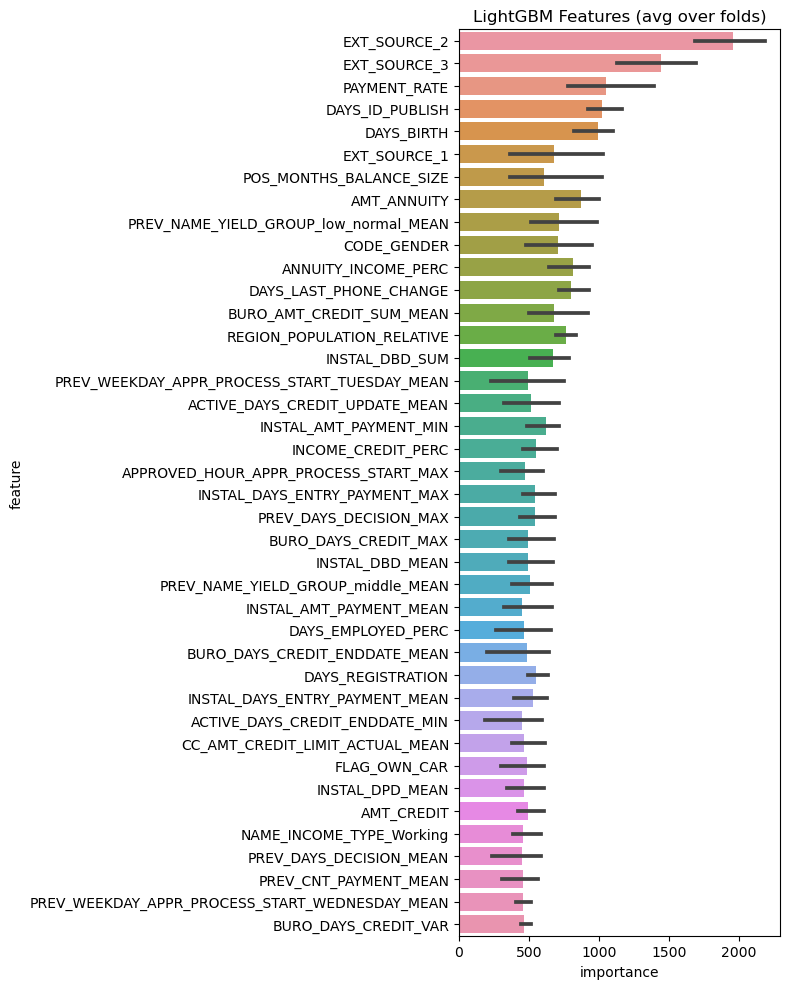

Training Final model - done in 233s


<Figure size 640x480 with 0 Axes>

In [22]:
mlflow.end_run()
with timer("Training Final model"):
    feat_import = kfold_lightgbm(num_folds=3, debug=True)

In [11]:
data = pd.read_csv("./Docs_projet7/df_model.csv")
print(feat_import.shape)
feats = feat_import['feature'][0:781]  # soit 781 feats

(2343, 3)


In [12]:
print(len(data.columns), len(feats.index))

781 781


In [26]:
liste_data = df.columns.to_list()
liste_feats = list(feats.values)
print(type(liste_data), type(liste_feats))
print(len(liste_data), len(liste_feats))

for feat in liste_feats : 
    if feat in liste_data :
        print(feat)
        

<class 'list'> <class 'list'>
789 781
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE

### Learning Curve

In [ ]:
from sklearn.model_selection import LearningCurveDisplay

LearningCurveDisplay.from_estimator(
   pipe, X_train, y_train, train_sizes=[0.2, 0.5, 0.8, 1], cv=5)

plt.savefig('learning_curve.png')
plt.show()
mlflow.log_artifact("learning_curve.png")

## Make the data for prediction

In [7]:
app_train = pd.read_csv(path + 'application_train.csv', nrows=30000)
df_dashboard = make_data(app_train)
df_dashboard = debug_json_characters(df_dashboard)
df_dashboard.to_csv("Docs_projet7/df_model_sample.csv", index=False)

Number of samples: 30000
Process application - done in 0s
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 10s
Previous applications df shape: (338857, 237)
Process previous_applications - done in 12s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 8s
Installments payments df shape: (339587, 22)
Process installments payments - done in 17s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 12s


In [8]:
df_dashboard = debug_json_characters(df_dashboard)
df_dashboard.to_csv("Docs_projet7/df_model_sample.csv", index=False)